# Init

In [1]:
from f_drosophila_infer import *
from f_data_prep import *
import seaborn as sns
from sklearn import linear_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [3]:
matplotlib.rcParams.update({'font.size':20})
matplotlib.rcParams['legend.frameon'] = False

# Load data

In [4]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

In [5]:
with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

In [6]:
val = np.hstack([cells_v+(6078*i) for i in range(5)])
cells_tt = np.delete(range(6078), cells_v)
tr = np.hstack([cells_tt+(6078*i) for i in range(5)])

In [7]:
def make_quad(X):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = X.shape[1]
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    return quad

In [8]:
quad = make_quad(all_init)
quad_t = np.copy(quad[tr])
y_t = np.copy(all_diff[tr])
quad_v = np.copy(quad[val])
y_v = np.copy(all_diff[val])

In [9]:
# model = Sequential()
# model.add(Dense(1, activation='linear', input_dim=4950))
# # model.add(Dense(99, activation='linear'))
# model.compile(optimizer='SGD', loss='mean_squared_error')
# hist = model.fit(quad_t, y_t[:,0:1], batch_size=50, epochs=200, validation_data=(quad_v, y_v[:,0:1]), verbose=0)

# yp = all_init[val][:,0:1] + model.predict(quad_v)
# yp[yp<0] = 0
# ya = all_init[val][:,0:1] + y_v[:,0:1]

# ferror = np.sum(np.abs(yp-ya)**2)/np.sum(np.abs(ya)**2)
# ferror

In [10]:
# model = Sequential()
# model.add(Dense(1, activation='linear', input_dim=4950))
# # model.add(Dense(99, activation='linear'))
# model.compile(optimizer='SGD', loss='mean_squared_error')
# hist = model.fit(quad_t, y_t[:,0:1], batch_size=50, epochs=200, validation_data=(quad_v, y_v[:,0:1]), verbose=0)

# yp = all_init[val][:,0:1] + model.predict(quad_v)
# yp[yp<0] = 0
# ya = all_init[val][:,0:1] + y_v[:,0:1]

# ferror = np.sum(np.abs(yp-ya))/np.sum(np.abs(ya))
# ferror

# Add columns ne by one
- no early stopping
- iterated until epoch=200

In [11]:
ferror_g1 = np.zeros(99)
for i in range(1,100):
    with open('./pickles/keras/addcol_mse/mse_%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
    yp = all_init[val][:,0:i] + res['pred']
    ya = all_init[val][:,0:i] + y_v[:,0:i]
    ferror_g1[i-1] = ((np.sum(np.abs(yp-ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2))[0]

## Frational error of Gene 1 as a function of # of columns included for training

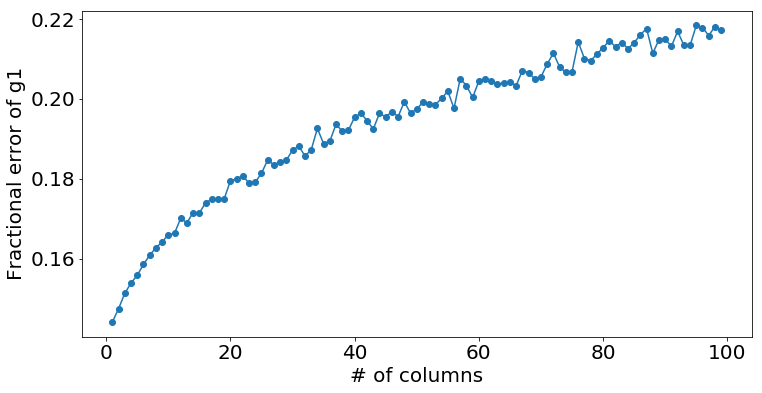

In [12]:
plt.figure(figsize=(12,6))
plt.plot(range(1,100), ferror_g1, 'o-')
plt.xlabel('# of columns')
plt.ylabel('Fractional error of g1')
plt.show()

## Train_loss and val_loss of Gene 1 (trained on output layer dim = 1)

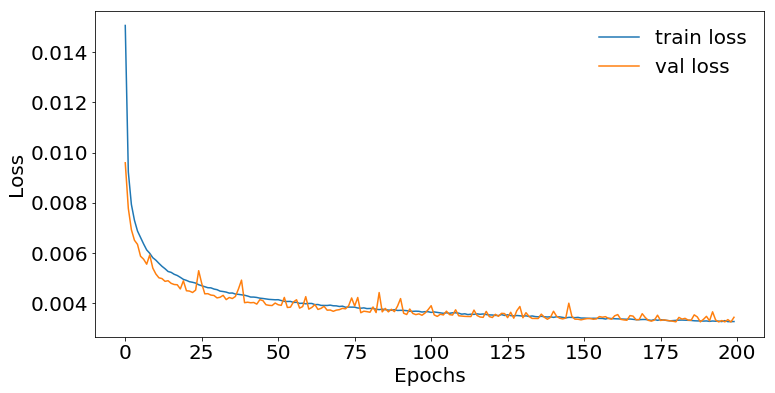

In [13]:
with open('./pickles/keras/addcol_mse/mse_1.pkl', 'rb') as f:
    res = pickle.load(f)
plt.figure(figsize=(12,6))
plt.plot(range(len(res['hist']['loss'])), res['hist']['loss'], label='train loss')
plt.plot(range(len(res['hist']['loss'])), res['hist']['val_loss'], label='val loss')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Fractional error
- train on output layer dim = 99
- no early stopping
- trained with epoch = 200

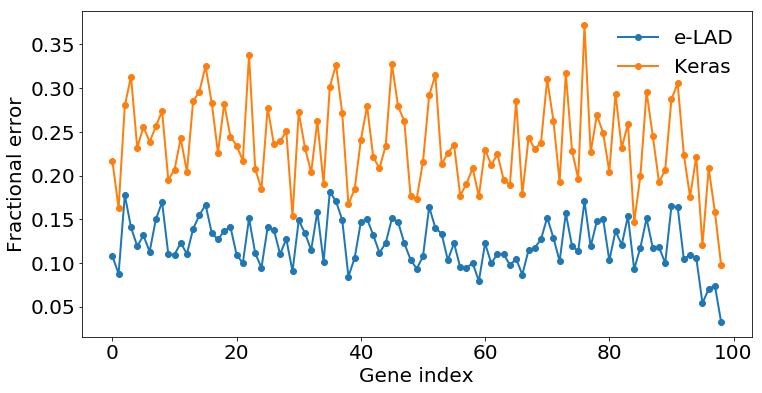

In [14]:
with open('./pickles/keras/addcol_mse/mse_99.pkl', 'rb') as f:
    res = pickle.load(f)
yp = all_init[val] + res['pred']
yp[yp<0] = 0
ya = all_init[val] + y_v

ferror = (np.sum(np.abs(yp-ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)

with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    lad = pickle.load(f)

plt.figure(figsize=(12,6))
plt.plot(range(99), lad['ferror'], 'o-', linewidth=2, label='e-LAD')
plt.plot(range(99), ferror, 'o-', linewidth=2, label='Keras')
plt.xlabel('Gene index')
plt.ylabel('Fractional error')
plt.legend()
plt.show()

# Train-test-validation
- early stopping, min_delta=0, monitor='val_loss'
- output layer dim = 99

In [15]:
with open('./pickles/keras/biowulf/ttv_mse.pkl', 'rb') as f:
    keras = pickle.load(f)

yp = all_init[val] + keras['pred']
yp[yp<0] = 0
ya = all_init[val] + y_v
error1 = np.abs(yp-ya)

ferror = (np.sum(np.abs(yp-ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)

res = {'pred': yp,
       'error': error1,
      'ferror': ferror,
      'hist': keras['hist']}

with open('./pickles/keras/ttv_mse/ttv_mse.pkl', 'wb') as f:
    pickle.dump(res,f)

## Fractional error, Distribution of $L1$ norm and $L_{2}^{2}$ of errors in validation cells

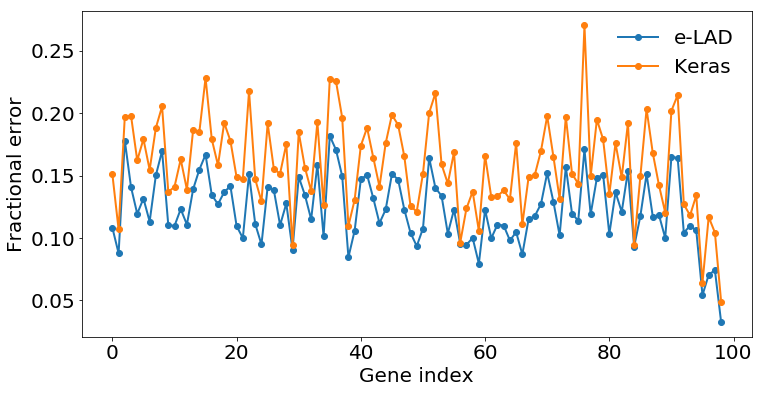

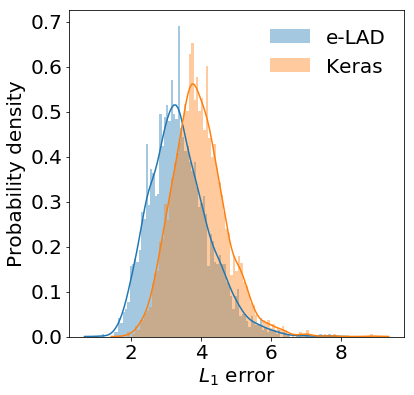

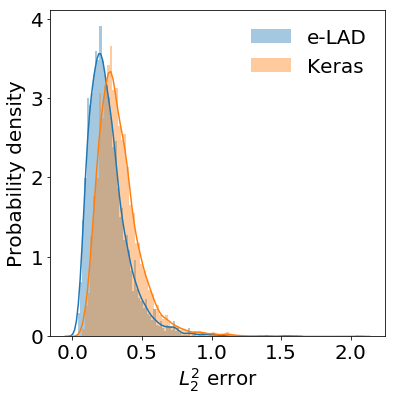

MannwhitneyuResult(statistic=2797486.0, pvalue=1.0650042079409512e-156)
MannwhitneyuResult(statistic=3039906.0, pvalue=2.258210168688655e-118)


In [16]:
with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    lad = pickle.load(f)
    
with open('./pickles/keras/ttv_mse/ttv_mse.pkl', 'rb') as f:
    keras = pickle.load(f)

plt.figure(figsize=(12,6))
plt.plot(range(99), lad['ferror'], 'o-', linewidth=2, label='e-LAD')
plt.plot(range(99), keras['ferror'], 'o-', linewidth=2, label='Keras')
plt.xlabel('Gene index')
plt.ylabel('Fractional error')
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
sns.distplot(np.sum(lad['error'], axis=1), bins=100, label='e-LAD')
sns.distplot(np.sum(keras['error'], axis=1), bins=100, label='Keras')
plt.xlabel('$L_{1}$ error')
plt.ylabel('Probability density')
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
sns.distplot(np.sum(lad['error']**2, axis=1), bins=100, label='e-LAD')
sns.distplot(np.sum(keras['error']**2, axis=1), bins=100, label='Keras')
plt.xlabel('$L_{2}^{2}$ error')
plt.ylabel('Probability density')
plt.legend()
plt.show()

print(stats.mannwhitneyu(np.sum(lad['error'], axis=1), np.sum(keras['error'], axis=1), alternative='less'))
print(stats.mannwhitneyu(np.sum(lad['error']**2, axis=1), np.sum(keras['error']**2, axis=1), alternative='less'))

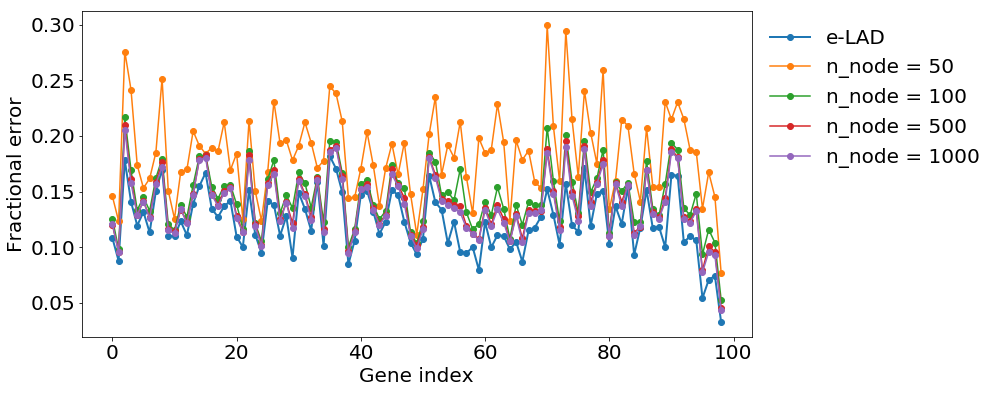

In [17]:
with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    lad = pickle.load(f)
    
plt.figure(figsize=(12,6))
plt.plot(range(99), lad['ferror'], 'o-', linewidth=2, label='e-LAD')

n_node = [50,100,500,1000]
for i in n_node:
    with open('./pickles/keras/ttv_mse/hidden/%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
    yp = all_init[val] + res['pred']
    yp[yp<0] = 0
    ya = all_init[val] + y_v
    ferror = np.sum(np.abs(yp-ya), axis=0)/np.sum(np.abs(ya), axis=0)
    plt.plot(range(99), ferror, 'o-', label = 'n_node = %s' % i)
plt.xlabel('Gene index')
plt.ylabel('Fractional error')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

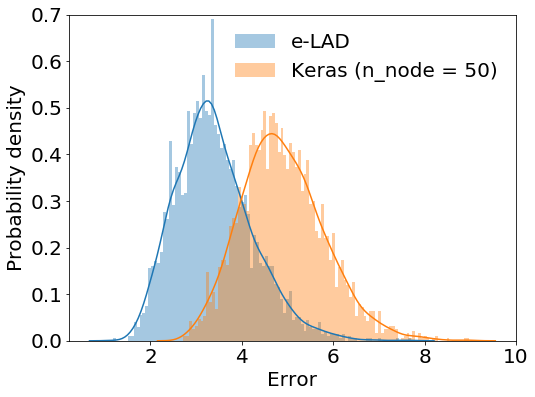

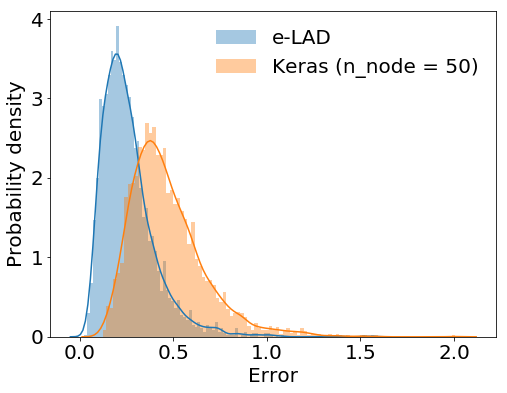

MannwhitneyuResult(statistic=1009716.0, pvalue=0.0)


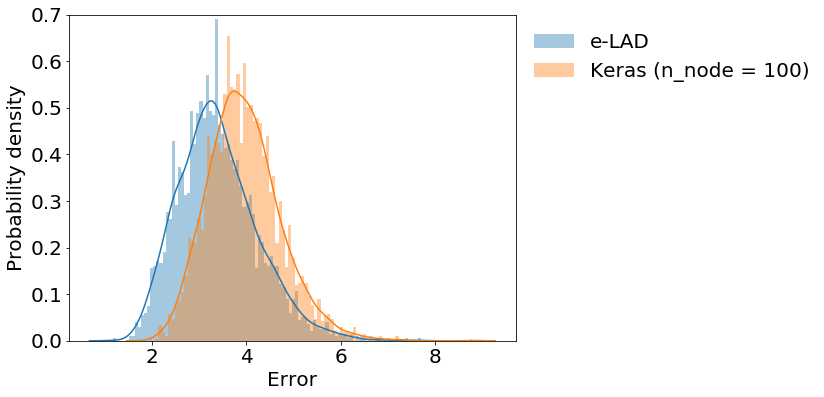

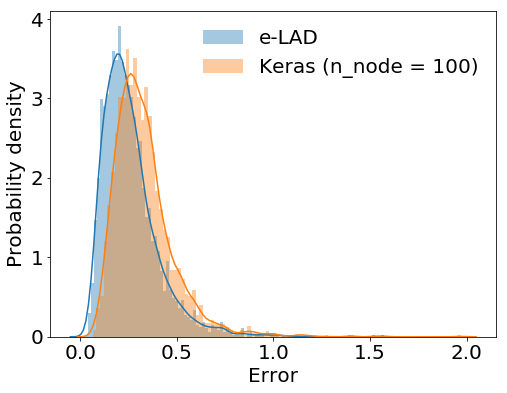

MannwhitneyuResult(statistic=2789689.0, pvalue=5.062088854870425e-158)


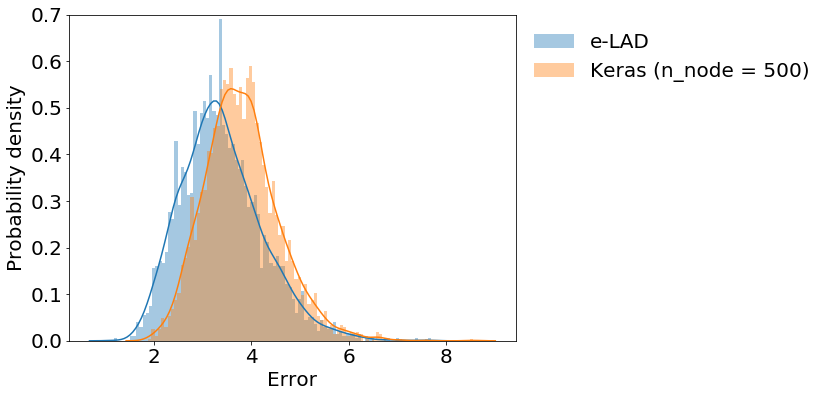

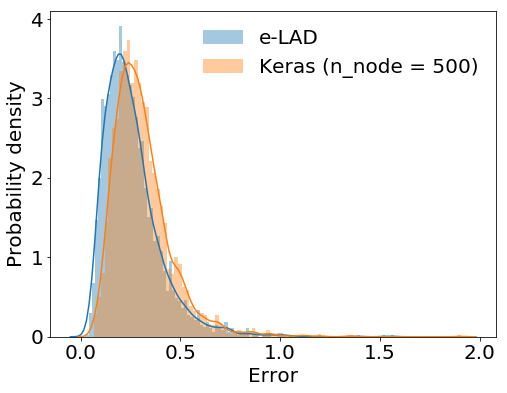

MannwhitneyuResult(statistic=3228576.0, pvalue=2.6181807959014953e-92)


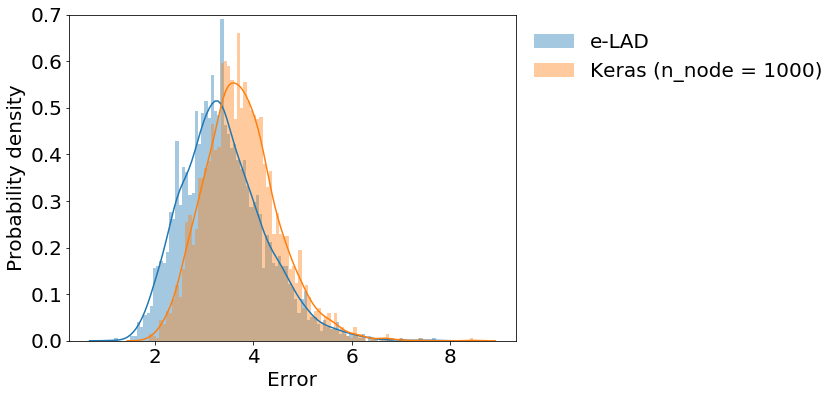

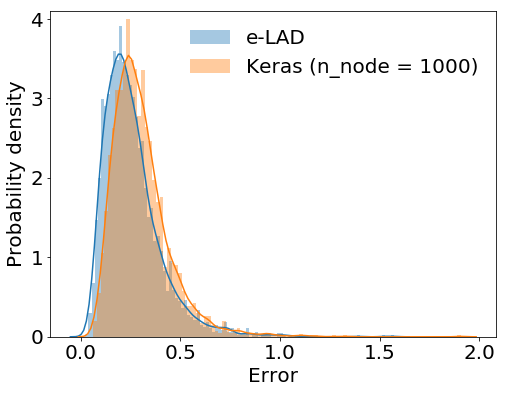

MannwhitneyuResult(statistic=3369175.0, pvalue=5.009738307005232e-75)


In [18]:
n_node = [50,100,500,1000]
for i in n_node:
    with open('./pickles/keras/ttv_mse/hidden/%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
    yp = all_init[val] + res['pred']
    ya = all_init[val] + y_v
    
    error = np.abs(yp-ya)
    plt.figure(figsize=(8,6))
    sns.distplot(np.sum(lad['error'], axis=1), bins=100, label='e-LAD')
    sns.distplot(np.sum(error, axis=1), bins=100, label='Keras (n_node = %s)' % i)
    plt.ylim(0,0.7)
    plt.xlabel('Error')
    plt.ylabel('Probability density')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.figure(figsize=(8,6))
    sns.distplot(np.sum(lad['error']**2, axis=1), bins=100, label='e-LAD')
    sns.distplot(np.sum(error**2, axis=1), bins=100, label='Keras (n_node = %s)' % i)
    plt.xlabel('Error')
    plt.ylabel('Probability density')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.show()
    print(stats.mannwhitneyu(np.sum(lad['error'], axis=1), np.sum(error, axis=1), alternative='less'))

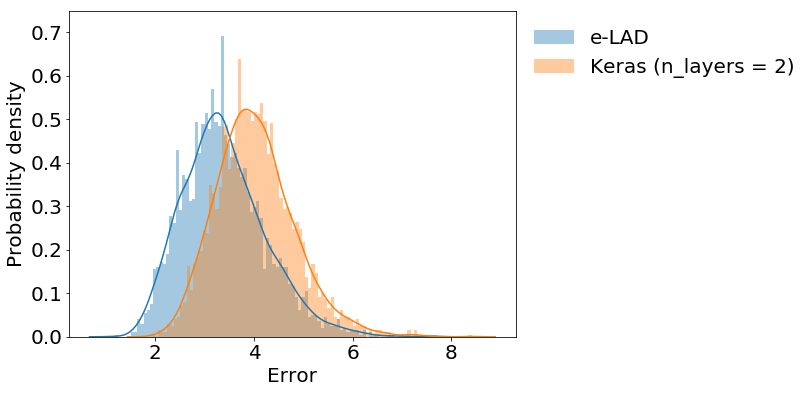

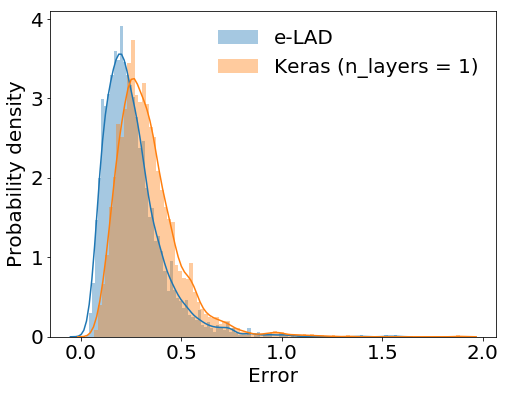

MannwhitneyuResult(statistic=2624568.0, pvalue=2.3113681810841244e-187)


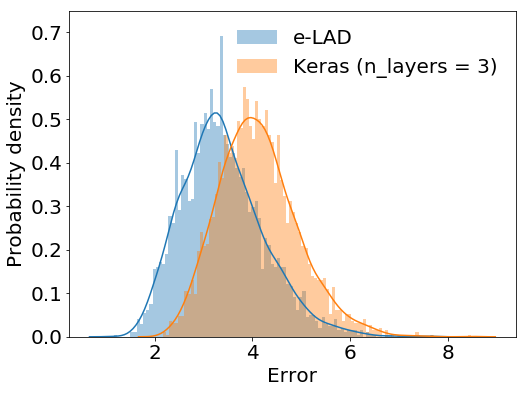

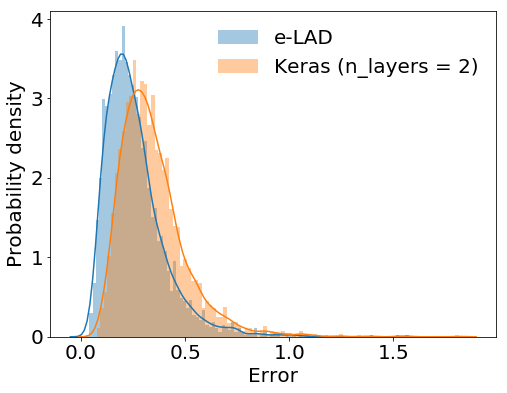

MannwhitneyuResult(statistic=2397447.0, pvalue=7.596640193998682e-232)


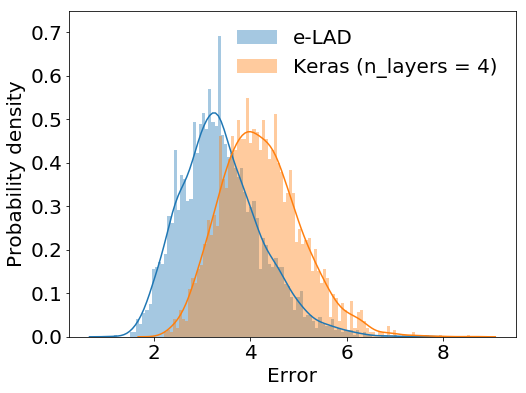

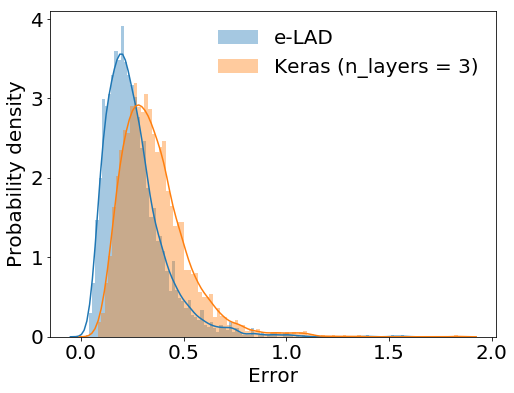

MannwhitneyuResult(statistic=2175114.0, pvalue=5.082779100978342e-280)


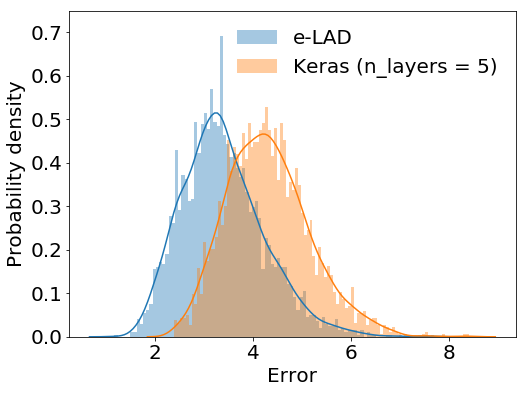

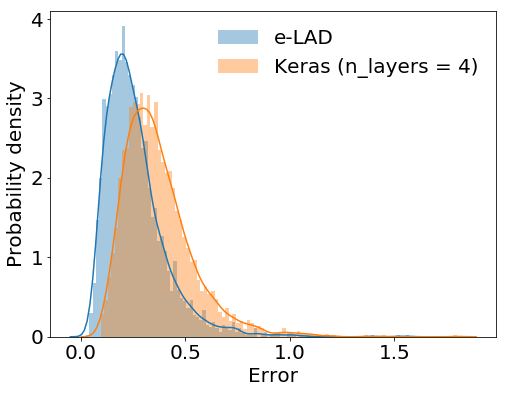

MannwhitneyuResult(statistic=1980647.0, pvalue=0.0)


In [19]:
n_layer = [1,2,3,4]
for i in n_layer:
    with open('./pickles/keras/ttv_mse/hidden/layers%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
    yp = all_init[val] + res['pred']
    ya = all_init[val] + y_v
    
    error = np.abs(yp-ya)
    plt.figure(figsize=(8,6))
    sns.distplot(np.sum(lad['error'], axis=1), bins=100, label='e-LAD')
    sns.distplot(np.sum(error, axis=1), bins=100, label='Keras (n_layers = %s)' % (i+1))
    plt.ylim(0,0.75)
    plt.xlabel('Error')
    plt.ylabel('Probability density')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.figure(figsize=(8,6))
    sns.distplot(np.sum(lad['error']**2, axis=1), bins=100, label='e-LAD')
    sns.distplot(np.sum(error**2, axis=1), bins=100, label='Keras (n_layers = %s)' % i)
    plt.xlabel('Error')
    plt.ylabel('Probability density')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    print(stats.mannwhitneyu(np.sum(lad['error'], axis=1), np.sum(error, axis=1), alternative='less'))